In [1]:
import os
import glob
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchsummary import summary

os.chdir('/VOLUME/nia_vent_asynchrony')
from module.datasets import preprocess_data#, set_dataloader, CustomDataset
from module.utils import load_and_stack_data, EarlyStopping
from model.VAE import VAE
from model.AsynchModel import AsynchModel
from module.metrics import calculate_any_metrics
from module.loss import calculate_vae_loss, calculate_bce_loss
import module.utils as cutils


In [2]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "2,3" 

In [3]:
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Current cuda device: 0
Count of using GPUs: 2


In [4]:
torch.cuda.is_available()

True

In [5]:
vae = VAE().cuda()
summary(vae, input_size=(2, 480), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 480]             176
       BatchNorm1d-2              [-1, 16, 480]              32
              ReLU-3              [-1, 16, 480]               0
         MaxPool1d-4              [-1, 16, 120]               0
            Conv1d-5              [-1, 32, 120]           2,592
       BatchNorm1d-6              [-1, 32, 120]              64
              ReLU-7              [-1, 32, 120]               0
         MaxPool1d-8               [-1, 32, 30]               0
            Conv1d-9               [-1, 64, 30]          10,304
      BatchNorm1d-10               [-1, 64, 30]             128
             ReLU-11               [-1, 64, 30]               0
           Linear-12                  [-1, 128]           3,968
           Linear-13                  [-1, 128]           3,968
           Linear-14                   

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [4]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu.pkl')
dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_2022-08-23.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)

In [3]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_239107_2022-08-25.pkl')
dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_295433_2022-08-25.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)

In [ ]:
print(dat_aju['flow_path'].nunique())
print(dat_aju['hospital_id_patient_id'].nunique())

In [5]:
num_na = dat['data'].apply(lambda x: np.isnan(x).sum())

In [6]:
num_na.value_counts().head(20)

0      372239
2       33268
8       31187
4       26309
10      24296
12      22652
6       22406
960     18214
32        206
30        185
34        120
38        117
40        105
36        103
42         83
962        73
958        68
198        18
98         17
96         17
Name: data, dtype: int64

In [5]:
dat

,flow_path,starttime,endtime,data,hospital_id_patient_id,wav_number,instance_index,label
0,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:21.831158+09:00,2021-09-28 02:00:29.814651+09:00,"[[40.69999694824219, -0.1450004577636718], [40...",1-002,91,0,0
1,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:29.831318+09:00,2021-09-28 02:00:37.814811+09:00,"[[42.600006103515625, 8.299999237060547], [39....",1-002,91,1,0
2,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:37.831478+09:00,2021-09-28 02:00:45.814971+09:00,"[[89.39999389648438, 4.47499942779541], [92.30...",1-002,91,2,0
3,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:45.831638+09:00,2021-09-28 02:00:53.815131+09:00,"[[34.80000305175781, -0.0399999618530273], [35...",1-002,91,3,0
4,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:53.831798+09:00,2021-09-28 02:01:01.815291+09:00,"[[40.600006103515625, -0.2350006103515625], [4...",1-002,91,4,0
...,...,...,...,...,...,...,...,...
69,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:11.994963+09:00,2019-04-30 16:09:19.978298+09:00,"[[426.0, 900.5], [443.5, 932.5], [451.0, 958.5...",2-002,123,310268,0
70,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:19.994965+09:00,2019-04-30 16:09:27.978300+09:00,"[[54.5, 470.0], [72.5, 490.0], [90.5, 510.0], ...",2-002,123,310269,0
71,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:27.994966+09:00,2019-04-30 16:09:35.978301+09:00,"[[288.5, 613.5], [317.5, 636.0], [336.5, 648.0...",2-002,123,310270,0
72,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:35.994968+09:00,2019-04-30 16:09:43.978303+09:00,"[[-286.0, 588.0], [-278.5, 581.0], [-269.0, 58...",2-002,123,310271,0


In [6]:
dat = dat[num_na<480]

In [3]:
dat_snu['data'].apply(lambda x : np.isnan(x).sum()).value_counts()

0    239107
Name: data, dtype: int64

In [5]:
dat = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3145286_2022-08-25.pkl')

In [75]:
dat['data'].apply(lambda x :np.isnan(x).sum()).value_counts()

0      2691039
4        96102
2        84727
8        73487
6        69133
        ...   
684          1
403          1
576          1
537          1
363          1
Name: data, Length: 548, dtype: int64

In [12]:
dat

,flow_path,starttime,endtime,data,hospital_id_patient_id,wav_number,instance_index,label
0,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:21.831158+09:00,2021-09-28 02:00:29.814651+09:00,"[[40.69999694824219, -0.1450004577636718], [40...",1-002,91,0,0
1,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:29.831318+09:00,2021-09-28 02:00:37.814811+09:00,"[[42.600006103515625, 8.299999237060547], [39....",1-002,91,1,0
2,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:37.831478+09:00,2021-09-28 02:00:45.814971+09:00,"[[89.39999389648438, 4.47499942779541], [92.30...",1-002,91,2,0
3,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:45.831638+09:00,2021-09-28 02:00:53.815131+09:00,"[[34.80000305175781, -0.0399999618530273], [35...",1-002,91,3,0
4,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:53.831798+09:00,2021-09-28 02:01:01.815291+09:00,"[[40.600006103515625, -0.2350006103515625], [4...",1-002,91,4,0
...,...,...,...,...,...,...,...,...
69,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:11.994963+09:00,2019-04-30 16:09:19.978298+09:00,"[[426.0, 900.5], [443.5, 932.5], [451.0, 958.5...",2-002,123,310268,0
70,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:19.994965+09:00,2019-04-30 16:09:27.978300+09:00,"[[54.5, 470.0], [72.5, 490.0], [90.5, 510.0], ...",2-002,123,310269,0
71,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:27.994966+09:00,2019-04-30 16:09:35.978301+09:00,"[[288.5, 613.5], [317.5, 636.0], [336.5, 648.0...",2-002,123,310270,0
72,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:35.994968+09:00,2019-04-30 16:09:43.978303+09:00,"[[-286.0, 588.0], [-278.5, 581.0], [-269.0, 58...",2-002,123,310271,0


In [ ]:
print(dat.groupby('hospital_id_patient_id')['label'].value_counts())

hospital_id_patient_id  label
1-002                   0         39034
                        2            22
1-003                   0        167584
                        2           351
                        1            64
                        3            24
1-004                   0         35539
2-002                   0         53970
                        2           473
                        3           180
                        1            10
2-003                   0         41981
2-004                   0         59422
                        2           166
                        3           129
2-007                   0        115661
                        2          1750
                        3           379
                        1             6
2-010                   0         35120
                        2           836
                        3           190
Name: label, dtype: int64


In [126]:
dat['hospital_id_patient_id'].str[0].value_counts()

2    310273
1    242618
Name: hospital_id_patient_id, dtype: int64

In [5]:
dat['split'] = 'train'
dat.loc[dat['hospital_id_patient_id']=='2-007','split'] = 'valid'
dat.loc[dat['hospital_id_patient_id']=='1-002','split'] = 'test'
dat.loc[dat['hospital_id_patient_id']=='2-002','split'] = 'test'

In [8]:
labelfreq = pd.concat([dat.groupby('split')['label'].value_counts(),
dat.groupby('split')['label'].value_counts(normalize=True)], axis=1)
labelfreq.columns = ['num', 'ratio']
print(labelfreq)
labelfreq.to_csv(osp.join(result_path,'label_freq_trainvaltest.csv'))

                num     ratio
split label                  
test  0       93004  0.992689
      2         495  0.005283
      3         180  0.001921
      1          10  0.000107
train 0      339646  0.994845
      2        1353  0.003963
      3         343  0.001005
      1          64  0.000187
valid 0      115661  0.981875
      2        1750  0.014856
      3         379  0.003217
      1           6  0.000051


In [63]:
print(dat['label'].value_counts())

0    548311
2      3598
3       902
1        80
Name: label, dtype: int64


In [ ]:
dat.columns

Index(['flow_path', 'starttime', 'endtime', 'data', 'hospital_id_patient_id',
       'wav_number', 'instance_index', 'label', 'split'],
      dtype='object')

In [ ]:
pd.Series(label).value_counts()

False    546664
True       3671
dtype: int64

In [ ]:
pd.Series(label).value_counts(normalize=True)

False    0.99333
True     0.00667
dtype: float64

In [ ]:
dat['label'].value_counts()

0    545763
2      3591
3       901
1        80
Name: label, dtype: int64

In [ ]:
dat['label'].value_counts(normalize=True)

0    0.991692
2    0.006525
3    0.001637
1    0.000145
Name: label, dtype: float64

In [ ]:
label.shape

(550335,)

In [ ]:
feature.shape

(550335, 480, 2)

In [5]:

# # bce_loss = torch.nn.BCELoss(reduction='mean')

# def calculate_vae_loss(out, xi, batch_size=None):
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
#     loss_r = bce_loss(out, xi)
#     # loss_r = ((out - xi)**2).sum()
#     loss_kl = torch.mean(.5 * torch.sum(mu.pow(2) + torch.exp(logVar) - 1 - logVar, 1))
#     # loss = torch.mean(loss_r) + loss_kl
#     loss = loss_r + loss_kl
#     return loss, loss_r, loss_kl

# def calculate_bce_loss(out, target, pos_weight=torch.tensor([5])):
#     if pos_weight is not None:
#         pos_weight = pos_weight.to(target)
#     bce_loss = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)
#     loss = bce_loss(out, target)
#     return loss


In [6]:
nowDate = cutils.get_today_string()

In [7]:
result_path = f'/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/{nowDate}'
os.makedirs(result_path, exist_ok=True)
print(result_path)

/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-30-04-48-27


In [103]:
dat

,flow_path,starttime,endtime,data,hospital_id_patient_id,wav_number,instance_index,label,split
0,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:21.831158+09:00,2021-09-28 02:00:29.814651+09:00,"[[40.69999694824219, -0.1450004577636718], [40...",1-002,91,0,0,test
1,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:29.831318+09:00,2021-09-28 02:00:37.814811+09:00,"[[42.600006103515625, 8.299999237060547], [39....",1-002,91,1,0,test
2,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:37.831478+09:00,2021-09-28 02:00:45.814971+09:00,"[[89.39999389648438, 4.47499942779541], [92.30...",1-002,91,2,0,test
3,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:45.831638+09:00,2021-09-28 02:00:53.815131+09:00,"[[34.80000305175781, -0.0399999618530273], [35...",1-002,91,3,0,test
4,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:53.831798+09:00,2021-09-28 02:01:01.815291+09:00,"[[40.600006103515625, -0.2350006103515625], [4...",1-002,91,4,0,test
...,...,...,...,...,...,...,...,...,...
69,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:11.994963+09:00,2019-04-30 16:09:19.978298+09:00,"[[426.0, 900.5], [443.5, 932.5], [451.0, 958.5...",2-002,123,310268,0,test
70,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:19.994965+09:00,2019-04-30 16:09:27.978300+09:00,"[[54.5, 470.0], [72.5, 490.0], [90.5, 510.0], ...",2-002,123,310269,0,test
71,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:27.994966+09:00,2019-04-30 16:09:35.978301+09:00,"[[288.5, 613.5], [317.5, 636.0], [336.5, 648.0...",2-002,123,310270,0,test
72,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:35.994968+09:00,2019-04-30 16:09:43.978303+09:00,"[[-286.0, 588.0], [-278.5, 581.0], [-269.0, 58...",2-002,123,310271,0,test


In [74]:
dat['split']='train'

In [ ]:
train_dataloader, val_dataloader, test_dataloader = preprocess_data(dat, set_train_weightedsampler=False, scale=True)

In [76]:
# train VAE
learning_rate = 1e-3
n_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

"""
Initialize the network and the Adam optimizer
"""
vae_model = VAE().to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience = 5, verbose = True, path = result_path, checkpoint_name='vae_model.pt')



"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
# 모델이 학습되는 동안 trainning loss를 track
train_losses = []
# 모델이 학습되는 동안 validation loss를 track
valid_losses = []
# epoch당 average training loss를 track
avg_train_losses = []
# epoch당 average validation loss를 track
avg_valid_losses = []


for epoch in range(n_epochs):
    print(f'Epoch {epoch}')
    vae_model.train()
    for i_step, data in enumerate(train_dataloader):
        xi, target = data
        xi = xi.to(device)
        batch_size = len(xi) 
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = vae_model(xi)
        assert (~out.isnan()).sum()>0
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        # kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        # loss = F.binary_cross_entropy(out, xi, size_average=False) + kl_divergence
        loss, loss_r, loss_kl = calculate_vae_loss(out, mu, logVar, xi, batch_size)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_step%100==0: print('step', i_step, 'loss', loss.item(), 'loss_r', loss_r.item(), 'loss_kl', loss_kl.item())

    ######################    
    # validate the model #
    ######################
    vae_model.eval() # prep model for evaluation
    y_prob = None
    y_target = None
    for i_step, data in enumerate(val_dataloader) :
        xi, target = data
        xi = xi.to(device)
        batch_size = len(xi)

        out, mu, logVar = vae_model(xi)
        loss, loss_r, loss_kl = calculate_vae_loss(out, mu, logVar, xi, batch_size)

        valid_losses.append(loss.item())


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
        
    epoch_len = len(str(n_epochs))


    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, vae_model)
    if early_stopping.early_stop:
        print("Early stopping")
        break


cuda
Epoch 0


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


step 0 loss 16.741785049438477 loss_r 0.7645362019538879 loss_kl 15.977249145507812
step 100 loss 1.2549030780792236 loss_r 0.6828201413154602 loss_kl 0.5720829963684082
step 200 loss 0.9288325309753418 loss_r 0.6805084347724915 loss_kl 0.24832412600517273
step 300 loss 0.8118099570274353 loss_r 0.6833440661430359 loss_kl 0.12846587598323822
step 400 loss 0.7619965672492981 loss_r 0.6858094930648804 loss_kl 0.07618707418441772
step 500 loss 0.7431113719940186 loss_r 0.6886036396026611 loss_kl 0.05450774356722832
step 600 loss 0.7313200235366821 loss_r 0.6903666257858276 loss_kl 0.040953412652015686
step 700 loss 0.7213893532752991 loss_r 0.6907889246940613 loss_kl 0.030600422993302345
step 800 loss 0.714242160320282 loss_r 0.691209077835083 loss_kl 0.023033108562231064
step 900 loss 0.7108907103538513 loss_r 0.691788911819458 loss_kl 0.019101807847619057
step 1000 loss 0.7102294564247131 loss_r 0.692378044128418 loss_kl 0.017851408571004868
step 1100 loss 0.7041040658950806 loss_r 0.69

TypeError: 'NoneType' object is not iterable

In [16]:
vae_model.eval()

VAE(
  (encoder_conv): Sequential(
    (0): Conv1d(2, 16, kernel_size=(5,), stride=(1,), padding=same, padding_mode=replicate)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=same, padding_mode=replicate)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same, padding_mode=replicate)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)

In [78]:
ventdys_model.load_state_dict(vae_model.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=['classifier.0.weight', 'classifier.0.bias', 'classifier.2.weight', 'classifier.2.bias'], unexpected_keys=['decoder_conv.0.weight', 'decoder_conv.0.bias', 'decoder_conv.1.weight', 'decoder_conv.1.bias', 'decoder_conv.1.running_mean', 'decoder_conv.1.running_var', 'decoder_conv.1.num_batches_tracked', 'decoder_conv.4.weight', 'decoder_conv.4.bias', 'decoder_conv.5.weight', 'decoder_conv.5.bias', 'decoder_conv.5.running_mean', 'decoder_conv.5.running_var', 'decoder_conv.5.num_batches_tracked', 'decoder_conv.8.weight', 'decoder_conv.8.bias', 'decoder_conv.9.weight', 'decoder_conv.9.bias', 'decoder_conv.9.running_mean', 'decoder_conv.9.running_var', 'decoder_conv.9.num_batches_tracked', 'encFC1.weight', 'encFC1.bias', 'encFC2.weight', 'encFC2.bias', 'decFC1.weight', 'decFC1.bias'])

In [73]:
summary(ventdys_model, input_size=(2, 480), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 480]             176
       BatchNorm1d-2              [-1, 16, 480]              32
              ReLU-3              [-1, 16, 480]               0
         MaxPool1d-4              [-1, 16, 120]               0
            Conv1d-5              [-1, 32, 120]           2,592
       BatchNorm1d-6              [-1, 32, 120]              64
              ReLU-7              [-1, 32, 120]               0
         MaxPool1d-8               [-1, 32, 30]               0
            Conv1d-9               [-1, 64, 30]          10,304
      BatchNorm1d-10               [-1, 64, 30]             128
             ReLU-11               [-1, 64, 30]               0
AdaptiveAvgPool1d-12                [-1, 64, 1]               0
          Flatten-13                   [-1, 64]               0
           Linear-14                   

In [26]:
dat_snu = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_239107_2022-08-25.pkl')
dat_aju = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_with_label_aju_295433_2022-08-25.pkl')
dat = pd.concat([dat_snu, dat_aju], axis=0)

In [4]:
dat['split'] = 'train'
dat.loc[dat['hospital_id_patient_id']=='2-007','split'] = 'valid'
dat.loc[dat['hospital_id_patient_id']=='1-002','split'] = 'test'
dat.loc[dat['hospital_id_patient_id']=='2-002','split'] = 'test'

In [37]:
dat['split'].value_counts()

train    340296
valid    106935
test      86888
Name: split, dtype: int64

In [45]:
pd.crosstab(dat['label'], dat['split'])

split,test,train,valid
label,,,
0,86441,338538,104826
1,10,63,6
2,339,1353,1750
3,98,342,353


In [10]:
train_dataloader, val_dataloader, test_dataloader = preprocess_data(dat, set_train_weightedsampler=True, scale=True)

no of train, val, test 339439 117633 93263


/VOLUME/nia_vent_asynchrony/module/datasets.py:83: RuntimeWarning: All-NaN slice encountered
  min_stat = np.nanmin(X_test, axis=1) # (instance, 2)
/VOLUME/nia_vent_asynchrony/module/datasets.py:84: RuntimeWarning: All-NaN slice encountered
  max_stat = np.nanmax(X_test, axis=1) # (instance, 2)


x_data (339439, 480, 2)
trans x_data torch.Size([339439, 2, 480])
trans y_data torch.Size([339439, 1, 1])
x_data (93263, 480, 2)
trans x_data torch.Size([93263, 2, 480])
trans y_data torch.Size([93263, 1, 1])
x_data (117633, 480, 2)
trans x_data torch.Size([117633, 2, 480])
trans y_data torch.Size([117633, 1, 1])
X.shape (339439, 480, 2) (117633, 480, 2) (93263, 480, 2)
Y class distribution 0.004159804853254987 0.014927783857482353 0.005393349982958568


In [13]:
result_path

'/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-26-10-32-15'

In [14]:
n_epochs = 50
learning_rate = 1e-3
optimizer = torch.optim.Adam(ventdys_model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience = 10, verbose = True, path = result_path, checkpoint_name='ventdys_model.pt')


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
# 모델이 학습되는 동안 trainning loss를 track
train_losses = []
# 모델이 학습되는 동안 validation loss를 track
valid_losses = []
# epoch당 average training loss를 track
avg_train_losses = []
# epoch당 average validation loss를 track
avg_valid_losses = []


for epoch in range(n_epochs):
    print(f'Epoch {epoch}')

    ventdys_model.train()
    for i_step, data in enumerate(train_dataloader):
        xi, target = data
        xi = xi.to(device)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)

        loss = calculate_bce_loss(out[:,1], target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # print('step', i_step, 'loss', loss.item())
    print('epoch', epoch, 'loss', loss.item())
    
    ######################    
    # validate the model #
    ######################
    ventdys_model.eval() # prep model for evaluation
    # y_prob = None
    # y_target = None
    for i_step, data in enumerate(val_dataloader) :
        xi, target = data
        xi = xi.to(device)
        batch_size = len(xi)
        target = target.to(device).squeeze(-1).squeeze(-1).float()
        out = ventdys_model(xi)
        loss = calculate_bce_loss(out[:,1], target)
        
        valid_losses.append(loss.item())


    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
        
    epoch_len = len(str(n_epochs))


    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')

    print(print_msg)

    # clear lists to track next epoch
    train_losses = []
    valid_losses = []

    early_stopping(valid_loss, ventdys_model)
    if early_stopping.early_stop:
        print("Early stopping")
        break



Epoch 0
epoch 0 loss 0.35173720121383667
[ 0/50] train_loss: 0.72927 valid_loss: 2.26298
Validation loss decreased (inf --> 2.262985).  Saving model ...
Epoch 1
epoch 1 loss 0.31655657291412354
[ 1/50] train_loss: 0.42231 valid_loss: 2.27667
EarlyStopping counter: 1 out of 10
Epoch 2
epoch 2 loss 0.3059040606021881
[ 2/50] train_loss: 0.30515 valid_loss: 1.64345
Validation loss decreased (2.262985 --> 1.643449).  Saving model ...
Epoch 3
epoch 3 loss 0.23901963233947754
[ 3/50] train_loss: 0.26836 valid_loss: 2.59644
EarlyStopping counter: 1 out of 10
Epoch 4
epoch 4 loss 0.1927817463874817
[ 4/50] train_loss: 0.24735 valid_loss: 2.00475
EarlyStopping counter: 2 out of 10
Epoch 5
epoch 5 loss 0.22639068961143494
[ 5/50] train_loss: 0.22329 valid_loss: 0.59842
Validation loss decreased (1.643449 --> 0.598416).  Saving model ...
Epoch 6
epoch 6 loss 0.13956838846206665
[ 6/50] train_loss: 0.19086 valid_loss: 1.18545
EarlyStopping counter: 1 out of 10
Epoch 7
epoch 7 loss 0.13200461864471

In [15]:
epoch

34

In [12]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


step 0 loss 0.7082130908966064


In [11]:
testset = test_dataloader.dataset

In [18]:
# vae 안했을때 
# 아마 /VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-23-09-40-08/checkpoint.pt
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)
test_perf

{'auroc': 0.74,
 'auprc': 0.01,
 'prec': 0.0,
 'recall': 0.01,
 'f1': 0.0,
 'f2': 0.0,
 'specificity': 0.98,
 'tn': 91228.0,
 'fp': 1856.0,
 'fn': 178.0,
 'tp': 1.0,
 'auprcf1': 0.01}

In [16]:
# vae 안했을때 
# 아마 /VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-23-09-40-08/checkpoint.pt
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)

In [90]:
# vae 했을때 

# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)
test_perf

{'auroc': 0.47,
 'auprc': 0.0,
 'prec': 0.0,
 'recall': 0.08,
 'f1': 0.0,
 'f2': 0.01,
 'specificity': 0.82,
 'tn': 75772.0,
 'fp': 16988.0,
 'fn': 462.0,
 'tp': 41.0,
 'auprcf1': 0.01}

In [25]:
# vae 왕창 했을때 
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
test_perf = calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.001)
test_perf

{'auroc': 0.74,
 'auprc': 0.01,
 'prec': 0.01,
 'recall': 0.5,
 'f1': 0.01,
 'f2': 0.03,
 'specificity': 0.85,
 'tn': 79530.0,
 'fp': 13554.0,
 'fn': 89.0,
 'tp': 90.0,
 'auprcf1': 0.02}

In [23]:
np.percentile(y_prob, perc).shape

(7,)

In [27]:
y_prob.max()

tensor(1.0000)

In [13]:
perc =  [.05, .1 , .25, .5, .75, .9, .95]
percentile = pd.DataFrame(np.percentile(y_prob, perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile.to_csv(osp.join(result_path, 'y_prob_percentile.csv'))
percentile

,0.05,0.10,0.25,0.50,0.75,0.90,0.95
y_prob,0.548583,0.548583,0.548583,0.548583,0.548583,0.548583,0.548583


In [20]:
np.percentile(y_prob, .3)

1.2509244473808495e-25

<AxesSubplot:>

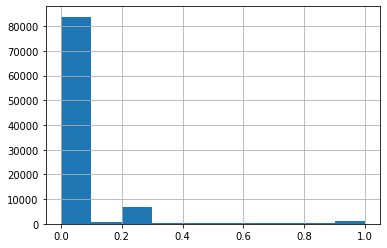

In [21]:
pd.Series(y_prob).hist()

In [50]:
np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])

/tmp/ipykernel_151376/2223798902.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])


110067.0

In [26]:
test_perf.update({'total_number': np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])})
pd.DataFrame(test_perf, index=['testset']).to_csv(osp.join(result_path, 'test_set_performance.csv'))

/tmp/ipykernel_120761/217727981.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  test_perf.update({'total_number': np.sum(test_perf[i] for i in ['tn','tp','fn','fp'])})


In [93]:
test_perf

{'auroc': 0.47,
 'auprc': 0.0,
 'prec': 0.0,
 'recall': 0.08,
 'f1': 0.0,
 'f2': 0.01,
 'specificity': 0.82,
 'tn': 75772.0,
 'fp': 16988.0,
 'fn': 462.0,
 'tp': 41.0,
 'auprcf1': 0.01,
 'total_number': 93263.0}

In [ ]:
# vae 왕창 했을때 
# testset_target = abnomal_testset.y_data.squeeze(-1).float()
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.8)

testset의 예측=1 인 metainfo 찾아서 그리기
label 있으면 표시하기
파일명: 

In [9]:
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-24-04-29-23/ventdys_model.pt'
ckpt_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/train/2022-08-26-10-32-15/ventdys_model.pt'
ckpt_dict = torch.load(ckpt_path)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
ventdys_model = AsynchModel(input_dim=2, padding_mode='replicate').to(device)
ventdys_model.load_state_dict(ckpt_dict, strict=False)

<All keys matched successfully>

In [59]:
dat_infer = pd.concat([pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_723989_2022-08-26.pkl'),
    pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_519403_2022-08-26.pkl')
])

In [3]:
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_with_label_snu_3145286_2022-08-25.pkl')
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-001_2-099_2582998_2022-09-02.pkl')
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-100_1-177_4972675_2022-09-03.pkl') # 4972675 rows 메모리 떄문에 한번에 못돌림
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-178_1-379_1953563_2022-09-02.pkl') # 
# dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/aju/instance_aju_2-100_2-249_3160686_2022-09-03.pkl')
dat_infer = pd.read_pickle('/VOLUME/nia_vent_asynchrony/data/processed_data/snu/instance_snu_1-001_1-099_7382836_2022-09-03.pkl') # TODO

In [5]:
len(dat_infer)

7382836

In [4]:
dat_infer['hospital_id_patient_id'].nunique()

99

In [ ]:
# dat_infer['hospital_id_patient_id'].drop_duplicates().sort_values().tolist()

In [4]:
dat_infer['split'] = 'test'

In [45]:
dat_infer_bak = dat_infer.copy()
# dat_infer = dat_infer_bak

In [57]:
dat_infer

,flow_path,starttime,endtime,data,hospital_id,patient_id,wav_number,hospital_id_patient_id,split
249,/ext_ssd/nia_vent/snu/20220831/1-045/AWF/1-045...,2021-11-18 10:33:34.559600+09:00,2021-11-18 10:33:42.543093+09:00,"[[27.44000244140625, 10.760000228881836], [26....",1,045,256,1-045,test
250,/ext_ssd/nia_vent/snu/20220831/1-045/AWF/1-045...,2021-11-18 10:33:42.559760+09:00,2021-11-18 10:33:50.543253+09:00,"[[-7.040008544921875, 5.104999542236328], [-6....",1,045,256,1-045,test
251,/ext_ssd/nia_vent/snu/20220831/1-045/AWF/1-045...,2021-11-18 10:33:50.559920+09:00,2021-11-18 10:33:58.543413+09:00,"[[49.27999877929688, 11.225000381469728], [48....",1,045,256,1-045,test
252,/ext_ssd/nia_vent/snu/20220831/1-045/AWF/1-045...,2021-11-18 10:33:58.560080+09:00,2021-11-18 10:34:06.543573+09:00,"[[-38.56000518798828, 6.994998931884766], [-36...",1,045,256,1-045,test
253,/ext_ssd/nia_vent/snu/20220831/1-045/AWF/1-045...,2021-11-18 10:34:06.560240+09:00,2021-11-18 10:34:14.543733+09:00,"[[-37.36000061035156, 7.114999771118164], [-34...",1,045,256,1-045,test
...,...,...,...,...,...,...,...,...,...
268,/ext_ssd/nia_vent/snu/20220831/1-086/AWF/1-086...,2022-01-16 09:35:44.220021+09:00,2022-01-16 09:35:52.203514+09:00,"[[57.19999694824219, 23.98999786376953], [56.6...",1,086,66,1-086,test
269,/ext_ssd/nia_vent/snu/20220831/1-086/AWF/1-086...,2022-01-16 09:35:52.220181+09:00,2022-01-16 09:36:00.203674+09:00,"[[-40.17000579833984, 9.619998931884766], [-33...",1,086,66,1-086,test
270,/ext_ssd/nia_vent/snu/20220831/1-086/AWF/1-086...,2022-01-16 09:36:00.220341+09:00,2022-01-16 09:36:08.203834+09:00,"[[-15.275001525878906, 8.65999984741211], [-14...",1,086,66,1-086,test
271,/ext_ssd/nia_vent/snu/20220831/1-086/AWF/1-086...,2022-01-16 09:36:08.220501+09:00,2022-01-16 09:36:16.203994+09:00,"[[3.5749969482421875, 6.979999542236328], [9.4...",1,086,66,1-086,test


In [5]:
dat_infer = dat_infer.iloc[6000000:,:]
# dat_infer = dat_infer.iloc[:700000,:]

In [6]:
len(dat_infer)

1382836

In [7]:
# testset = ...
_, _, test_dataloader = preprocess_data(dat_infer, scale=True)
# 1,000,000 rows, elapsed 

no of train, val, test 0 0 1370486
x_data (1370486, 480, 2)
trans x_data torch.Size([1370486, 2, 480])
trans y_data torch.Size([1370486, 1, 1])
X.shape (0, 480, 2) (1370486, 480, 2)
Y class distribution 0.0 0.0


In [12]:
# predict testset 
ventdys_model.eval()

y_prob = None
for i_step, data in enumerate(test_dataloader):
    xi, target = data
    xi = xi.to(device)
    target = target.to(device).squeeze(-1).squeeze(-1).float() # torch.Size([bs, 1])
    out = ventdys_model(xi)

    
    loss = calculate_bce_loss(out[:,1], target)

    prob = F.softmax(out, dim=1)[:,1].detach().cpu()
    # pred = y_proba>0.5
    y_prob = prob if y_prob is None else torch.cat([y_prob, prob])

    # pred_list.append(out.detach().cpu().numpy())
    if i_step%1000==0: print('step', i_step, 'loss', loss.item())


step 0 loss -1.5914945619566495e+21
step 1000 loss -1.0794100923142085e+21


In [13]:
testset = test_dataloader.dataset

In [27]:
# test_metainfo = testset.metainfo
# test_metainfo

In [14]:
testset_pred = testset.metainfo
testset_pred['y_pred_prob'] = y_prob
testset_pred['y_pred'] = y_prob>0.5
if 'label' in testset_pred.columns:
    testset_pred['y_target'] = testset_pred['label'].isin([2,1])

In [15]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,split,y_pred_prob,y_pred
180,/ext_ssd/nia_vent/snu/20220831/1-068/AWF/1-068...,2021-12-11 09:24:22.359846+09:00,2021-12-11 09:24:30.343339+09:00,1,068,15,1-068,test,6.550997e-08,False
181,/ext_ssd/nia_vent/snu/20220831/1-068/AWF/1-068...,2021-12-11 09:24:30.360006+09:00,2021-12-11 09:24:38.343499+09:00,1,068,15,1-068,test,2.518153e-10,False
182,/ext_ssd/nia_vent/snu/20220831/1-068/AWF/1-068...,2021-12-11 09:24:38.360166+09:00,2021-12-11 09:24:46.343659+09:00,1,068,15,1-068,test,8.974237e-13,False
183,/ext_ssd/nia_vent/snu/20220831/1-068/AWF/1-068...,2021-12-11 09:24:46.360326+09:00,2021-12-11 09:24:54.343819+09:00,1,068,15,1-068,test,5.991095e-10,False
184,/ext_ssd/nia_vent/snu/20220831/1-068/AWF/1-068...,2021-12-11 09:24:54.360486+09:00,2021-12-11 09:25:02.343979+09:00,1,068,15,1-068,test,1.708195e-10,False
...,...,...,...,...,...,...,...,...,...,...
439,/ext_ssd/nia_vent/snu/20220831/1-026/AWF/1-026...,2021-10-18 11:58:53.991592+09:00,2021-10-18 11:59:01.975085+09:00,1,026,144,1-026,test,1.098263e-10,False
440,/ext_ssd/nia_vent/snu/20220831/1-026/AWF/1-026...,2021-10-18 11:59:01.991752+09:00,2021-10-18 11:59:09.975245+09:00,1,026,144,1-026,test,5.706872e-07,False
441,/ext_ssd/nia_vent/snu/20220831/1-026/AWF/1-026...,2021-10-18 11:59:09.991912+09:00,2021-10-18 11:59:17.975405+09:00,1,026,144,1-026,test,1.943615e-06,False
442,/ext_ssd/nia_vent/snu/20220831/1-026/AWF/1-026...,2021-10-18 11:59:17.992072+09:00,2021-10-18 11:59:25.975565+09:00,1,026,144,1-026,test,7.631979e-07,False


In [16]:
testset_pred['hospital_id_patient_id'].unique()

array(['1-068', '1-024', '1-020', '1-090', '1-040', '1-015', '1-002',
       '1-063', '1-031', '1-046', '1-057', '1-053', '1-087', '1-097',
       '1-074', '1-093', '1-088', '1-028', '1-026'], dtype=object)

In [31]:
# testset_pred = testset_pred_bak

In [23]:
# testset_pred = pd.concat([testset_pred, testset_pred_bak])

In [24]:
# testset_pred = testset_pred_bak

In [25]:
# testset_pred_bak = testset_pred.copy()

In [17]:
perc =  [.05, .1 , .25, .5, .75, .9, .95, .99, .999]
percentile = pd.DataFrame(np.percentile(testset_pred['y_pred_prob'], perc).reshape(1, -1), columns=perc, index=['y_prob'])
percentile

,0.050,0.100,0.250,0.500,0.750,0.900,0.950,0.990,0.999
y_prob,6.374082e-31,1.310866e-27,2.209457e-24,1.623765e-22,1.669417e-21,4.488612e-21,5.949174e-21,7.561986e-21,7.964497e-21


<AxesSubplot:>

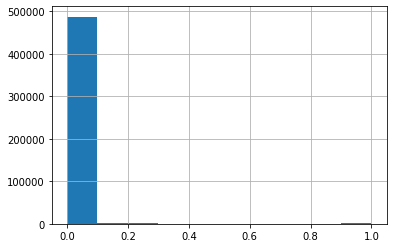

In [ ]:
testset_pred['y_pred_prob'].hist()

In [ ]:
testset_pred['y_pred'].value_counts()

False    1943204
True       38901
Name: y_pred, dtype: int64

In [ ]:
testset_pred['y_pred'].value_counts(normalize=True)

False    0.980374
True     0.019626
Name: y_pred, dtype: float64

In [ ]:
testset_pred

,flow_path,starttime,endtime,hospital_id,patient_id,wav_number,hospital_id_patient_id,split,y_pred_prob,y_pred
0,/ext_ssd/nia_vent/snu/20220831/1-055/AWF/1-055...,2021-11-24 20:00:23.682564+09:00,2021-11-24 20:00:31.666057+09:00,1,055,74,1-055,test,1.794760e-08,False
1,/ext_ssd/nia_vent/snu/20220831/1-055/AWF/1-055...,2021-11-24 20:00:31.682724+09:00,2021-11-24 20:00:39.666217+09:00,1,055,74,1-055,test,1.458113e-05,False
2,/ext_ssd/nia_vent/snu/20220831/1-055/AWF/1-055...,2021-11-24 20:00:39.682884+09:00,2021-11-24 20:00:47.666377+09:00,1,055,74,1-055,test,2.259394e-10,False
3,/ext_ssd/nia_vent/snu/20220831/1-055/AWF/1-055...,2021-11-24 20:00:47.683044+09:00,2021-11-24 20:00:55.666537+09:00,1,055,74,1-055,test,3.269175e-08,False
4,/ext_ssd/nia_vent/snu/20220831/1-055/AWF/1-055...,2021-11-24 20:00:55.683204+09:00,2021-11-24 20:01:03.666697+09:00,1,055,74,1-055,test,1.217398e-07,False
...,...,...,...,...,...,...,...,...,...,...
242,/ext_ssd/nia_vent/snu/20220831/1-070/AWF/1-070...,2021-12-15 13:32:37.873628+09:00,2021-12-15 13:32:45.857121+09:00,1,070,26,1-070,test,2.703266e-08,False
243,/ext_ssd/nia_vent/snu/20220831/1-070/AWF/1-070...,2021-12-15 13:32:45.873788+09:00,2021-12-15 13:32:53.857281+09:00,1,070,26,1-070,test,1.082545e-08,False
244,/ext_ssd/nia_vent/snu/20220831/1-070/AWF/1-070...,2021-12-15 13:32:53.873948+09:00,2021-12-15 13:33:01.857441+09:00,1,070,26,1-070,test,1.986270e-07,False
245,/ext_ssd/nia_vent/snu/20220831/1-070/AWF/1-070...,2021-12-15 13:33:01.874108+09:00,2021-12-15 13:33:09.857601+09:00,1,070,26,1-070,test,3.888555e-08,False


In [41]:
testset_pred['hospital_id_patient_id'].min()+'_'+testset_pred['hospital_id_patient_id'].max()

'1-008_1-099'

In [19]:
result_path = '/VOLUME/nia_vent_asynchrony/result/baseline_220818/infer'

In [29]:
path = osp.join(result_path, f'testset_{testset_pred["hospital_id_patient_id"].min()+"_"+testset_pred["hospital_id_patient_id"].max()}_{len(testset_pred)}_pred.csv')
testset_pred.to_csv(path)
path

'/VOLUME/nia_vent_asynchrony/result/baseline_220818/infer/testset_1-001_1-099_5334684_pred.csv'

In [23]:
fn = glob.glob(result_path+'/test*_tmp*')
ls = []
for fi in fn:
    ls.append(pd.read_csv(fi, index_col=0))

In [24]:
testset_pred = pd.concat(ls)

In [26]:
testset_pred['hospital_id_patient_id'].nunique()

99

In [27]:
testset_pred['hospital_id_patient_id'].min()

'1-001'

In [28]:
testset_pred['hospital_id_patient_id'].max()

'1-099'

In [46]:
testset_pred['conf_matrix'] = ''
testset_pred.loc[(testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='tp'
testset_pred.loc[(~testset_pred['y_target'])&(testset_pred['y_pred']),'conf_matrix']='fp'
testset_pred.loc[(testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='fn'
testset_pred.loc[(~testset_pred['y_target'])&(~testset_pred['y_pred']),'conf_matrix']='tn'

In [47]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'].isin([2,1]))

label,False,True
y_pred,,
False,47852,170
True,44908,333


In [48]:
pd.crosstab(testset_pred['y_pred'], testset_pred['label'])

label,0,1,2,3
y_pred,,,,
False,47769,0,170,83
True,44812,10,323,96


In [50]:
testset_pred['conf_matrix'].value_counts()

tn    47852
fp    44908
tp      333
fn      170
Name: conf_matrix, dtype: int64

In [14]:
testset_target = testset.y_data.squeeze(-1).float()
metrics = ['prec','recall','f1','f2','specificity',
                     'tn','fp','fn','tp',
                     'auroc','auprc']
calculate_any_metrics(testset_target, metrics, probs=y_prob, threshold=0.5)

{'auroc': 0.64,
 'auprc': 0.0,
 'prec': 0.0,
 'recall': 0.01,
 'f1': 0.0,
 'f2': 0.0,
 'specificity': 0.95,
 'tn': 88467.0,
 'fp': 4617.0,
 'fn': 177.0,
 'tp': 2.0,
 'auprcf1': 0.0}

<AxesSubplot:>

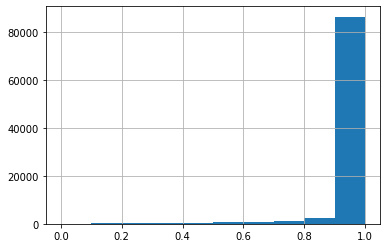

In [161]:
pd.Series(y_prob).hist()

In [163]:
dat

,flow_path,starttime,endtime,data,hospital_id_patient_id,wav_number,instance_index,label,split
0,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:21.831158+09:00,2021-09-28 02:00:29.814651+09:00,"[[40.69999694824219, -0.1450004577636718], [40...",1-002,91,0,0,test
1,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:29.831318+09:00,2021-09-28 02:00:37.814811+09:00,"[[42.600006103515625, 8.299999237060547], [39....",1-002,91,1,0,test
2,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:37.831478+09:00,2021-09-28 02:00:45.814971+09:00,"[[89.39999389648438, 4.47499942779541], [92.30...",1-002,91,2,0,test
3,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:45.831638+09:00,2021-09-28 02:00:53.815131+09:00,"[[34.80000305175781, -0.0399999618530273], [35...",1-002,91,3,0,test
4,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2021-09-28 02:00:53.831798+09:00,2021-09-28 02:01:01.815291+09:00,"[[40.600006103515625, -0.2350006103515625], [4...",1-002,91,4,0,test
...,...,...,...,...,...,...,...,...,...
69,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:11.994963+09:00,2019-04-30 16:09:19.978298+09:00,"[[426.0, 900.5], [443.5, 932.5], [451.0, 958.5...",2-002,123,310268,0,test
70,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:19.994965+09:00,2019-04-30 16:09:27.978300+09:00,"[[54.5, 470.0], [72.5, 490.0], [90.5, 510.0], ...",2-002,123,310269,0,test
71,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:27.994966+09:00,2019-04-30 16:09:35.978301+09:00,"[[288.5, 613.5], [317.5, 636.0], [336.5, 648.0...",2-002,123,310270,0,test
72,/VOLUME/nia_vent_asynchrony/data/raw_data/base...,2019-04-30 16:09:35.994968+09:00,2019-04-30 16:09:43.978303+09:00,"[[-286.0, 588.0], [-278.5, 581.0], [-269.0, 58...",2-002,123,310271,0,test


In [165]:
dat['hospital_id_patient_id'].str[0]

0     1
1     1
2     1
3     1
4     1
     ..
69    2
70    2
71    2
72    2
73    2
Name: hospital_id_patient_id, Length: 552891, dtype: object

In [170]:
dat['data'].head().apply(lambda x: np.nanmedian(x, axis=0))

0     [40.80000305175781, 0.7924995422363281]
1    [39.100006103515625, 0.3049993515014648]
2     [40.69999694824219, 1.3849992752075195]
3                  [40.05000305175781, 0.125]
4     [40.80000305175781, 1.0999999046325684]
Name: data, dtype: object